# Description ENG

# Description RU

В датасет были включены как кадры из аниме-сериала, так и ограниченное количество фан-артов схожего художественного стиля для повышения обобщающей способности модели.

# Imports/Setup

In [40]:
import os, random, math
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import timm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("torch:", torch.__version__, "cuda:", torch.cuda.is_available())
print("pillow:", Image.__version__)
print("timm:", timm.__version__)
print("sklearn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)


print("torch:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

torch: 2.5.1 cuda: True
pillow: 11.1.0
timm: 1.0.22
sklearn: 1.7.2
matplotlib: 3.10.8
torch: 2.5.1
torch.version.cuda: 12.1
cuda available: True
gpu: NVIDIA GeForce RTX 4070 SUPER


# Data and Classes

In [35]:
DATA_DIR = Path("data/results")
assert DATA_DIR.exists(), DATA_DIR.resolve()

classes = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])
counts = {c: len(list((DATA_DIR/c).glob("*.jpg"))) for c in classes}
classes, counts

(['kakashi', 'might_guy', 'sasuke'],
 {'kakashi': 88, 'might_guy': 88, 'sasuke': 88})

# Preview dataset

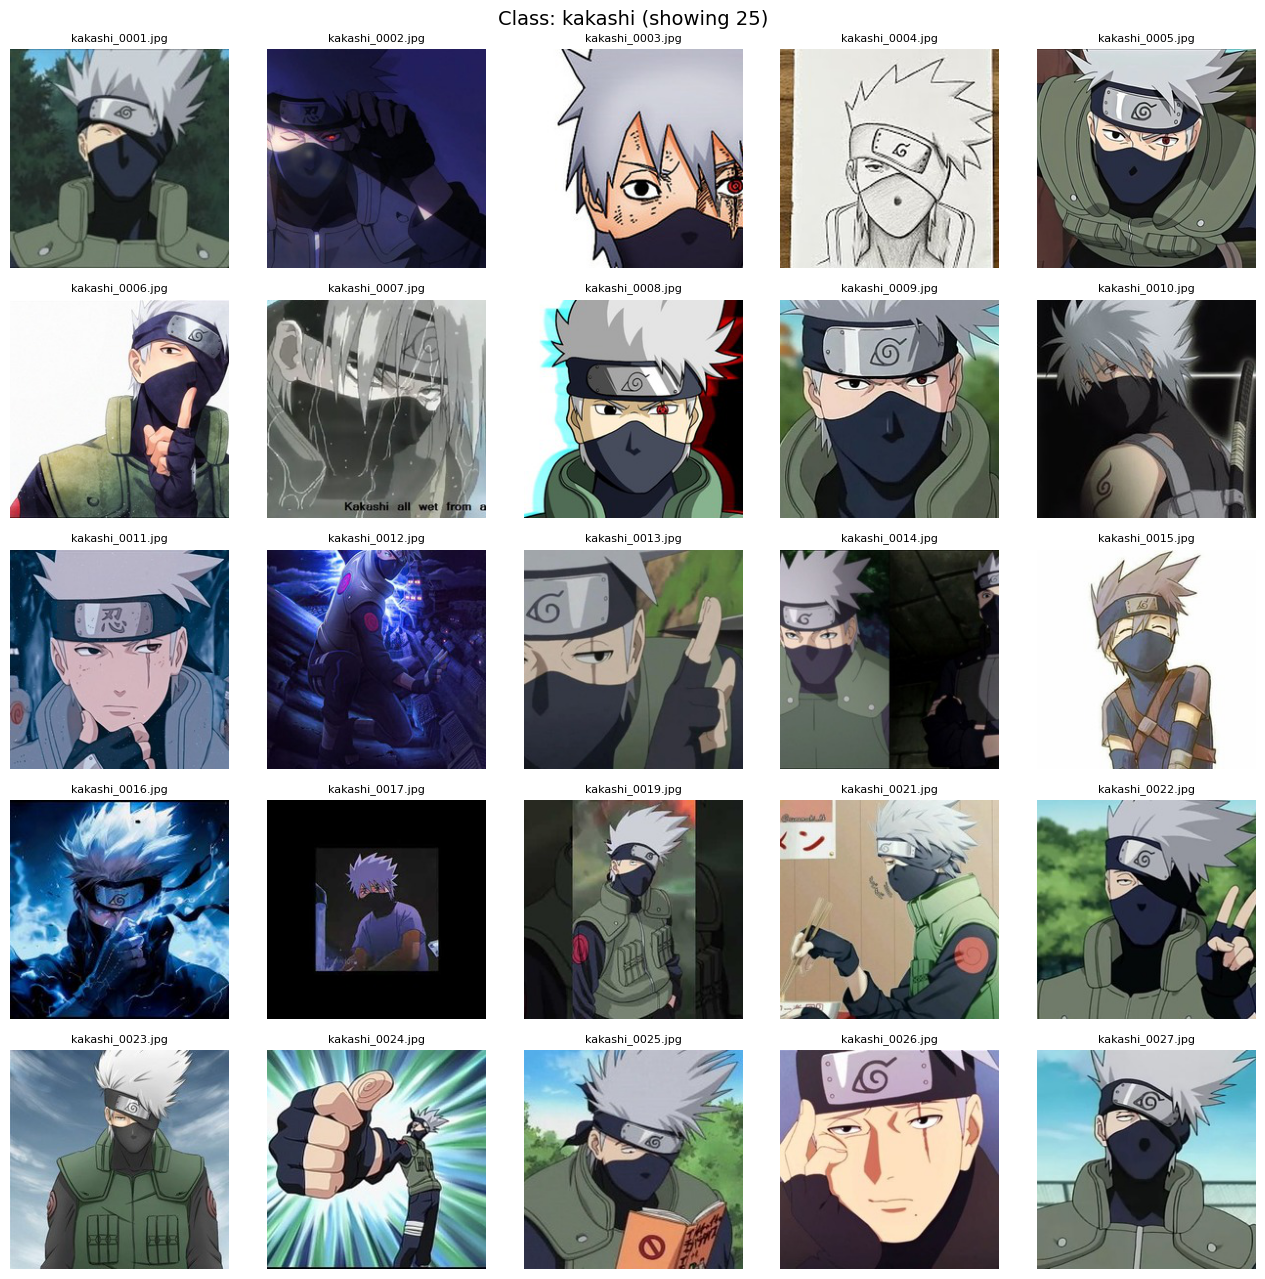

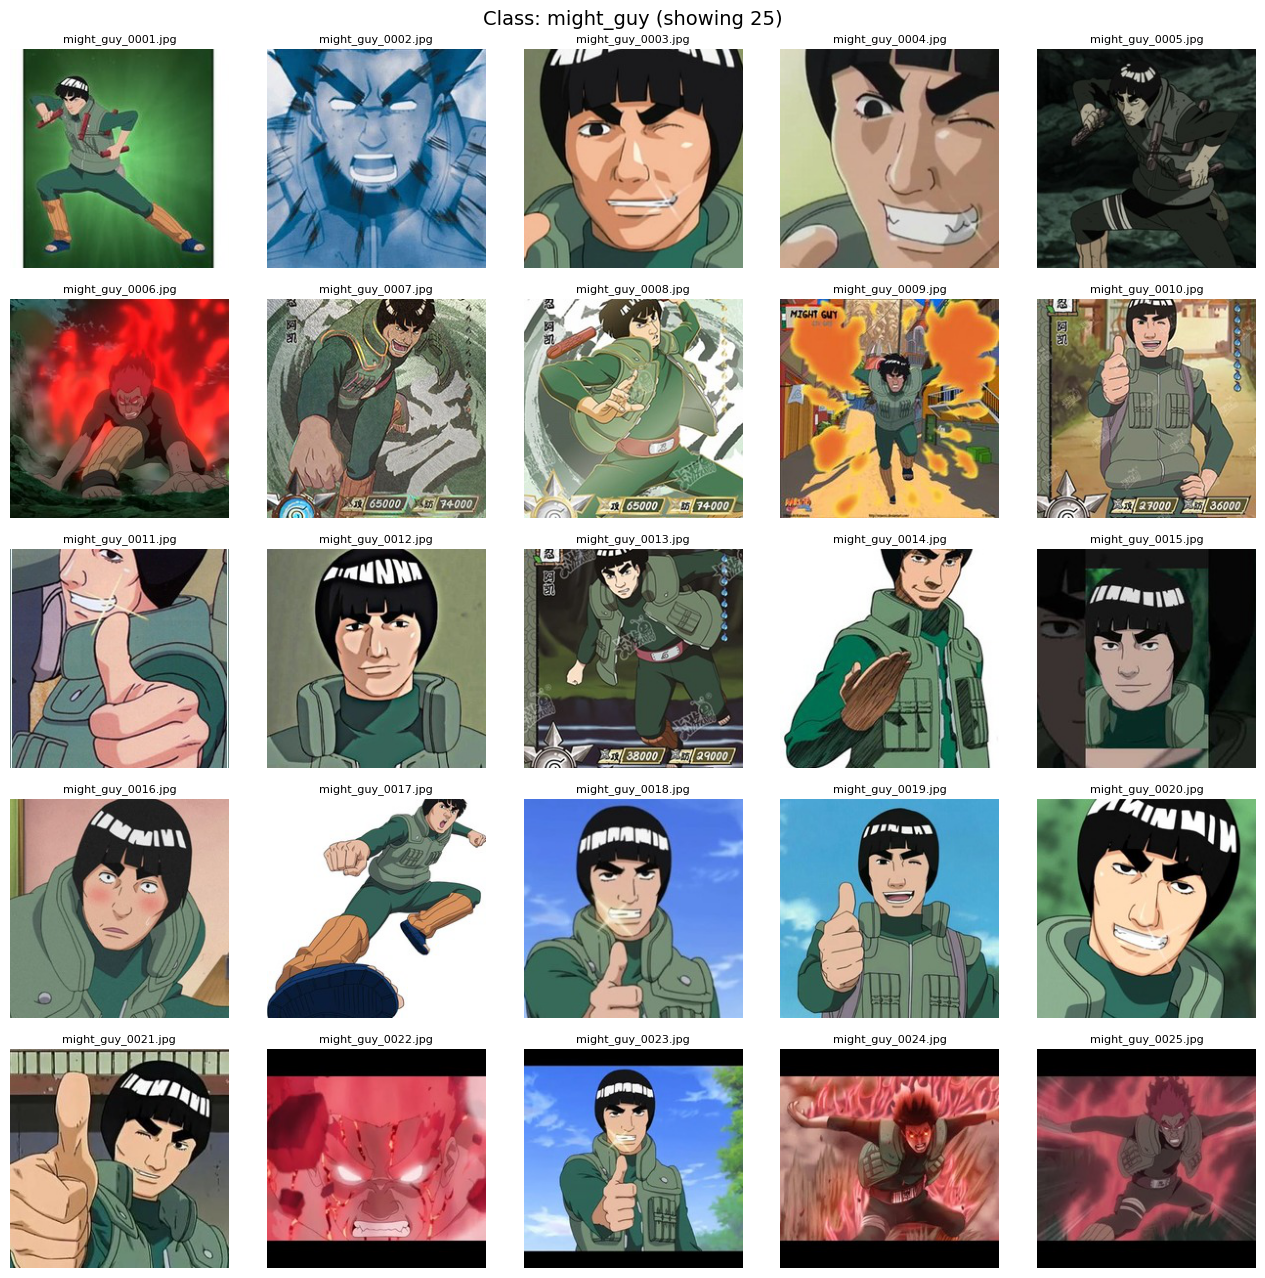

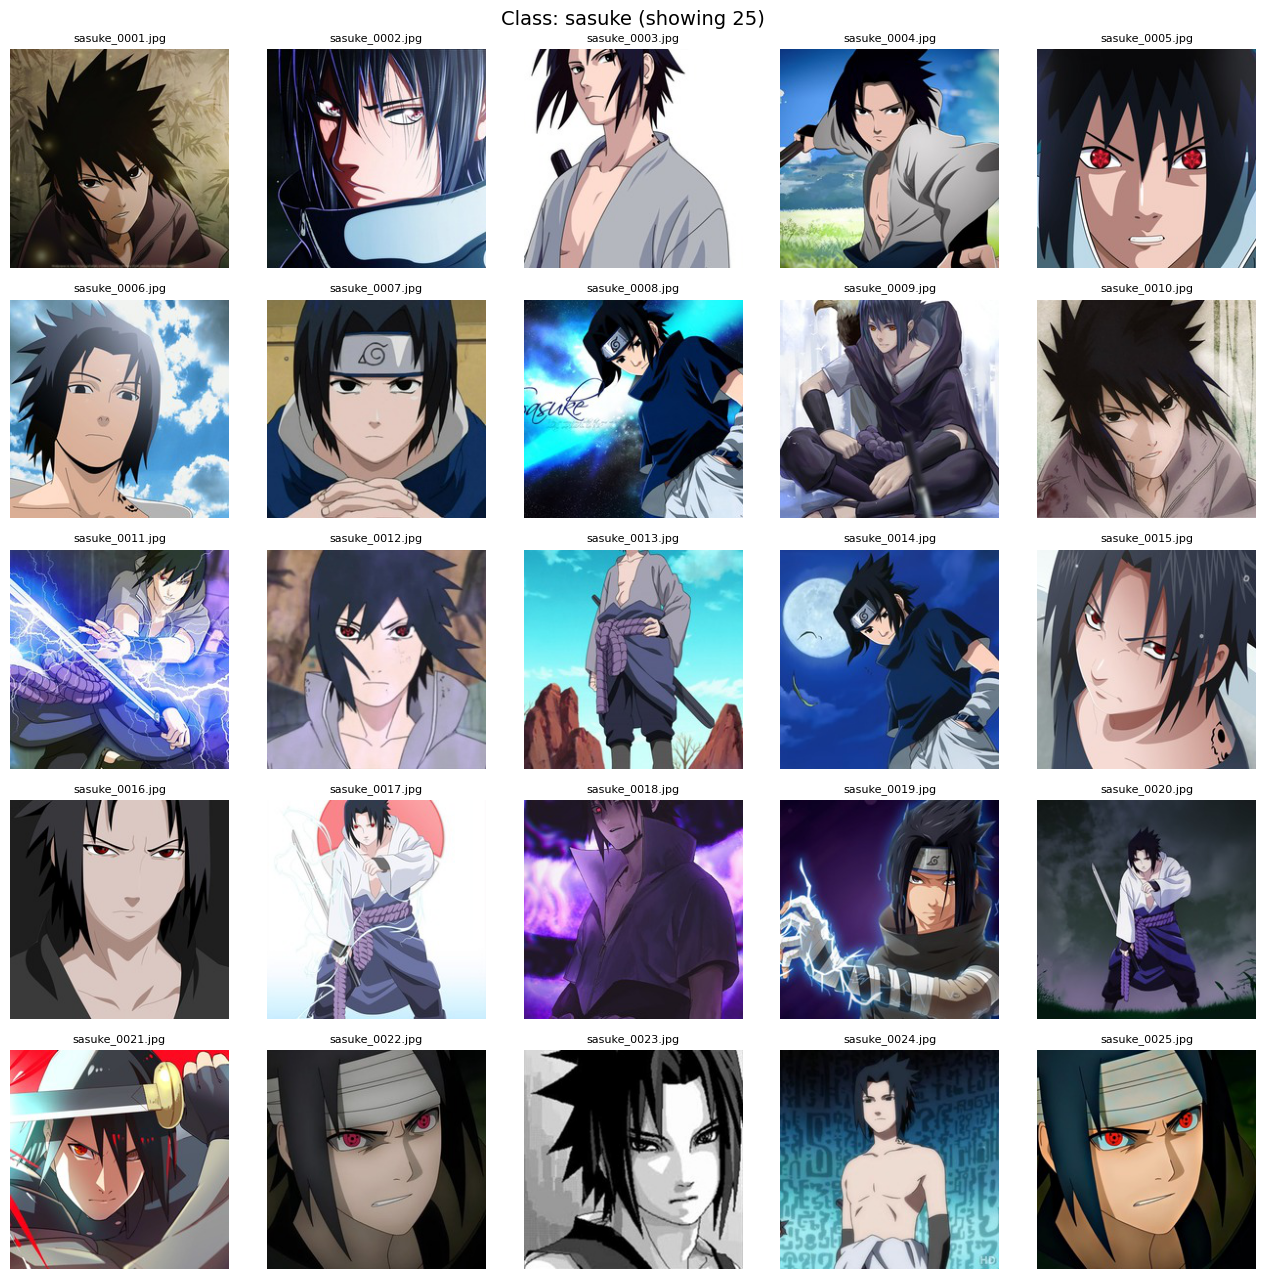

In [4]:
def show_grid(class_name: str, n=25, cols=5):
    paths = sorted((DATA_DIR / class_name).glob("*.jpg"))[:n]
    rows = math.ceil(len(paths) / cols)
    plt.figure(figsize=(cols * 2.6, rows * 2.6))
    for i, p in enumerate(paths, 1):
        img = Image.open(p)
        ax = plt.subplot(rows, cols, i)
        ax.imshow(img)
        ax.set_title(p.name, fontsize=8)
        ax.axis("off")
    plt.suptitle(f"Class: {class_name} (showing {len(paths)})", fontsize=14)
    plt.tight_layout()
    plt.show()

for c in classes:
    show_grid(c, n=25, cols=5)

# Prepear train/val and augmentation

In [36]:
# --- воспроизводимость ---
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

# --- параметры ---
DATA_DIR = "data/results"
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

# --- аугментации ---
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.10
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
])

val_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
])

# --- датасет ---
full_ds = datasets.ImageFolder(DATA_DIR, transform=train_tfms)
class_to_idx = full_ds.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(class_to_idx)

class_to_idx, idx_to_class

# --- split 80 / 20 ---
g = torch.Generator().manual_seed(SEED)
n = len(full_ds)
n_val = int(0.2 * n)
n_train = n - n_val

train_ds, val_ds = random_split(
    full_ds,
    [n_train, n_val],
    generator=g
)

# IMPORTANT: для val подменяем transform
val_ds.dataset = datasets.ImageFolder(DATA_DIR, transform=val_tfms)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

num_classes, (len(train_ds), len(val_ds))


(3, (212, 52))

# Fine-tuning model №1

In [37]:
import torch
import torch.nn as nn

def accuracy_from_logits(logits, y):
    pred = logits.argmax(dim=1)
    return (pred == y).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, criterion, device="cuda"):
    model.eval()
    total_loss, total_acc, n_batches = 0.0, 0.0, 0
    all_preds, all_targets = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item()
        total_acc += accuracy_from_logits(logits, y)
        n_batches += 1

        all_preds.append(logits.argmax(dim=1).detach().cpu())
        all_targets.append(y.detach().cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    return total_loss / n_batches, total_acc / n_batches, all_preds, all_targets

def train_one_epoch(model, loader, optimizer, criterion, device="cuda"):
    model.train()
    total_loss, total_acc, n_batches = 0.0, 0.0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy_from_logits(logits, y)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches



In [38]:
import timm

model_name = "resnet18"
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model = model.to(device)

# freeze всё
for p in model.parameters():
    p.requires_grad = False

# разморозим только классификатор (у resnet это fc)
for name, p in model.named_parameters():
    if "fc" in name or "classifier" in name or "head" in name:
        p.requires_grad = True

# проверка: сколько параметров обучаем
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
trainable, total


(1539, 11178051)

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-4)

EPOCHS_STAGE1 = 3

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS_STAGE1 + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device=device)
    va_loss, va_acc, _, _ = evaluate(model, val_loader, criterion, device=device)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    print(f"[Stage1][{epoch}/{EPOCHS_STAGE1}] "
          f"train loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val loss={va_loss:.4f} acc={va_acc:.3f}")


[Stage1][1/3] train loss=1.1008 acc=0.263 | val loss=1.0810 acc=0.316
[Stage1][2/3] train loss=1.0820 acc=0.376 | val loss=1.0689 acc=0.397
[Stage1][3/3] train loss=1.0562 acc=0.501 | val loss=1.0586 acc=0.494


In [9]:
# unfreeze всё
for p in model.parameters():
    p.requires_grad = True

# маленький lr для тонкой подстройки
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

EPOCHS_STAGE2 = 6

best_val_acc = -1.0
best_path = "best_resnet18.pth"

for epoch in range(1, EPOCHS_STAGE2 + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device=device)
    va_loss, va_acc, _, _ = evaluate(model, val_loader, criterion, device=device)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), best_path)

    print(f"[Stage2][{epoch}/{EPOCHS_STAGE2}] "
          f"train loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val loss={va_loss:.4f} acc={va_acc:.3f} | best={best_val_acc:.3f}")


[Stage2][1/6] train loss=1.0356 acc=0.510 | val loss=1.0268 acc=0.572 | best=0.572
[Stage2][2/6] train loss=0.9915 acc=0.696 | val loss=0.9959 acc=0.684 | best=0.684
[Stage2][3/6] train loss=0.9591 acc=0.730 | val loss=0.9654 acc=0.756 | best=0.756
[Stage2][4/6] train loss=0.9130 acc=0.809 | val loss=0.9344 acc=0.781 | best=0.781
[Stage2][5/6] train loss=0.8827 acc=0.830 | val loss=0.9076 acc=0.878 | best=0.878
[Stage2][6/6] train loss=0.8285 acc=0.879 | val loss=0.8678 acc=0.919 | best=0.919


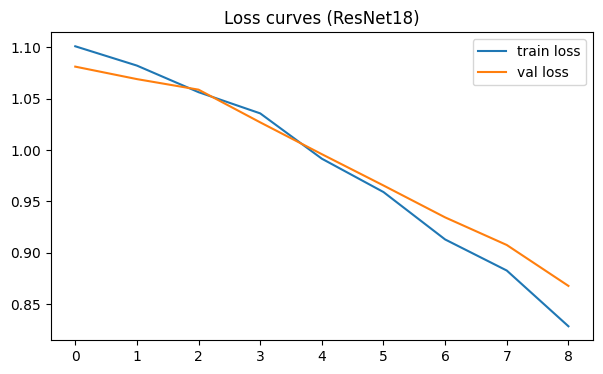

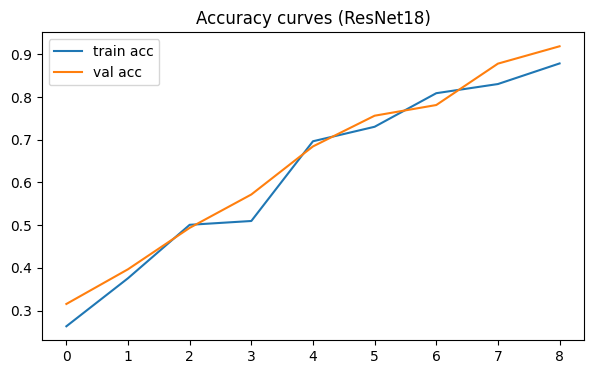

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.legend()
plt.title("Loss curves (ResNet18)")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.legend()
plt.title("Accuracy curves (ResNet18)")
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_6752\4109696867.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_resnet18.pth", map

Best ResNet18 val acc: 0.9187500178813934


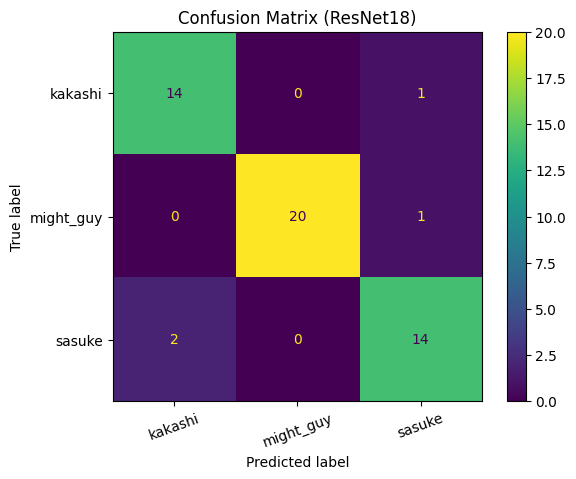

In [11]:
import timm
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_model = timm.create_model("resnet18", pretrained=False, num_classes=num_classes).to(device)
best_model.load_state_dict(torch.load("best_resnet18.pth", map_location=device))

criterion = nn.CrossEntropyLoss()
val_loss, val_acc, y_pred, y_true = evaluate(best_model, val_loader, criterion, device=device)

print("Best ResNet18 val acc:", val_acc)

labels = [idx_to_class[i] for i in range(num_classes)]
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(values_format="d")
plt.xticks(rotation=20)
plt.title("Confusion Matrix (ResNet18)")
plt.show()

# Fine-tuning model №2

In [12]:
import timm
import torch
import torch.nn as nn

model2_name = "convnext_tiny"
model2 = timm.create_model(model2_name, pretrained=True, num_classes=num_classes).to(device)

# 1) freeze вообще всё
for p in model2.parameters():
    p.requires_grad = False

# 2) разморозить только head (и иногда финальный norm рядом с головой)
UNFREEZE_KEYS = ("head.", "classifier.", "fc.", "final.")  # безопасный набор
for name, p in model2.named_parameters():
    if name.startswith(UNFREEZE_KEYS):
        p.requires_grad = True

# если вдруг timm назвал голову чуть иначе, выведем что разморожено:
unfrozen = [name for name, p in model2.named_parameters() if p.requires_grad]
print("Unfrozen params:", unfrozen[:30], "..." if len(unfrozen) > 30 else "")
print("Unfrozen count:", len(unfrozen))

trainable2 = sum(p.numel() for p in model2.parameters() if p.requires_grad)
total2 = sum(p.numel() for p in model2.parameters())
trainable2, total2


Unfrozen params: ['head.norm.weight', 'head.norm.bias', 'head.fc.weight', 'head.fc.bias'] 
Unfrozen count: 4


(3843, 27822435)

In [13]:
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model2.parameters()),
    lr=3e-4, weight_decay=1e-4
)

EPOCHS2_STAGE1 = 3
history2 = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS2_STAGE1 + 1):
    tr_loss, tr_acc = train_one_epoch(model2, train_loader, optimizer2, criterion2, device=device)
    va_loss, va_acc, _, _ = evaluate(model2, val_loader, criterion2, device=device)

    history2["train_loss"].append(tr_loss)
    history2["train_acc"].append(tr_acc)
    history2["val_loss"].append(va_loss)
    history2["val_acc"].append(va_acc)

    print(f"[ConvNeXt Stage1][{epoch}/{EPOCHS2_STAGE1}] "
          f"train loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val loss={va_loss:.4f} acc={va_acc:.3f}")


[ConvNeXt Stage1][1/3] train loss=1.1627 acc=0.395 | val loss=1.0025 acc=0.472
[ConvNeXt Stage1][2/3] train loss=0.9436 acc=0.545 | val loss=0.8687 acc=0.622
[ConvNeXt Stage1][3/3] train loss=0.7529 acc=0.746 | val loss=0.7539 acc=0.719


In [14]:
# unfreeze всё
for p in model2.parameters():
    p.requires_grad = True

optimizer2 = torch.optim.AdamW(model2.parameters(), lr=1e-4, weight_decay=1e-4)

EPOCHS2_STAGE2 = 6
best_val_acc2 = max(history2["val_acc"]) if history2["val_acc"] else -1.0
best_path2 = "best_convnext_tiny.pth"

for epoch in range(1, EPOCHS2_STAGE2 + 1):
    tr_loss, tr_acc = train_one_epoch(model2, train_loader, optimizer2, criterion2, device=device)
    va_loss, va_acc, _, _ = evaluate(model2, val_loader, criterion2, device=device)

    history2["train_loss"].append(tr_loss)
    history2["train_acc"].append(tr_acc)
    history2["val_loss"].append(va_loss)
    history2["val_acc"].append(va_acc)

    if va_acc > best_val_acc2:
        best_val_acc2 = va_acc
        torch.save(model2.state_dict(), best_path2)

    print(f"[ConvNeXt Stage2][{epoch}/{EPOCHS2_STAGE2}] "
          f"train loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val loss={va_loss:.4f} acc={va_acc:.3f} | best={best_val_acc2:.3f}")


[ConvNeXt Stage2][1/6] train loss=1.0404 acc=0.685 | val loss=0.3869 acc=0.850 | best=0.850
[ConvNeXt Stage2][2/6] train loss=0.1461 acc=0.939 | val loss=0.1346 acc=0.984 | best=0.984
[ConvNeXt Stage2][3/6] train loss=0.0483 acc=0.978 | val loss=0.0581 acc=0.984 | best=0.984
[ConvNeXt Stage2][4/6] train loss=0.0066 acc=1.000 | val loss=0.0649 acc=0.984 | best=0.984
[ConvNeXt Stage2][5/6] train loss=0.0016 acc=1.000 | val loss=0.0292 acc=0.984 | best=0.984
[ConvNeXt Stage2][6/6] train loss=0.0017 acc=1.000 | val loss=0.0234 acc=0.984 | best=0.984


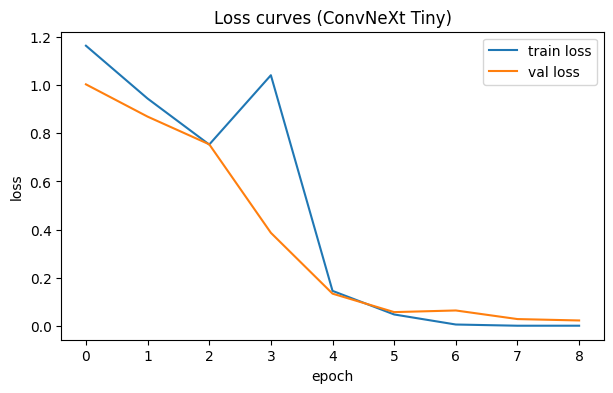

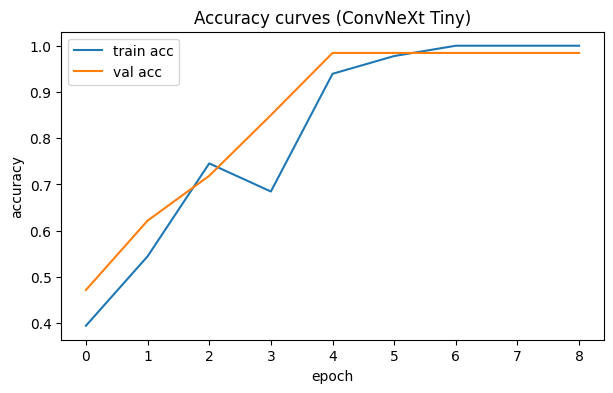

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(history2["train_loss"], label="train loss")
plt.plot(history2["val_loss"], label="val loss")
plt.legend()
plt.title("Loss curves (ConvNeXt Tiny)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(history2["train_acc"], label="train acc")
plt.plot(history2["val_acc"], label="val acc")
plt.legend()
plt.title("Accuracy curves (ConvNeXt Tiny)")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()


Best ConvNeXt val acc: 0.984375


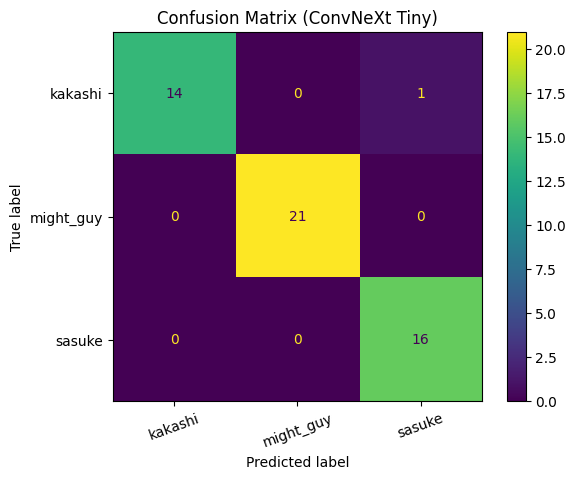

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

best_model2 = timm.create_model("convnext_tiny", pretrained=False, num_classes=num_classes).to(device)
best_model2.load_state_dict(torch.load(best_path2, map_location=device, weights_only=True))

val_loss2, val_acc2, y_pred2, y_true2 = evaluate(best_model2, val_loader, criterion2, device=device)
print("Best ConvNeXt val acc:", val_acc2)

labels = [idx_to_class[i] for i in range(num_classes)]
cm2 = confusion_matrix(y_true2, y_pred2)

disp = ConfusionMatrixDisplay(cm2, display_labels=labels)
disp.plot(values_format="d")
plt.xticks(rotation=20)
plt.title("Confusion Matrix (ConvNeXt Tiny)")
plt.show()


# Export model

In [20]:
import torch
import timm

IMG_SIZE = 224
best_onnx_path = "best_convnext_tiny.onnx"

# грузим лучшую модель на CPU
onnx_model = timm.create_model("convnext_tiny", pretrained=False, num_classes=num_classes)
state = torch.load("best_convnext_tiny.pth", map_location="cpu", weights_only=True)
onnx_model.load_state_dict(state)
onnx_model.eval()

dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)

torch.onnx.export(
    onnx_model,
    dummy,
    best_onnx_path,
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}},
    opset_version=17
)

print("Saved ONNX:", best_onnx_path)


Saved ONNX: best_convnext_tiny.onnx


# Testing model on test dataset

test classes: {'kakashi': 0, 'might_guy': 1, 'sasuke': 2}
External test accuracy: 1.0


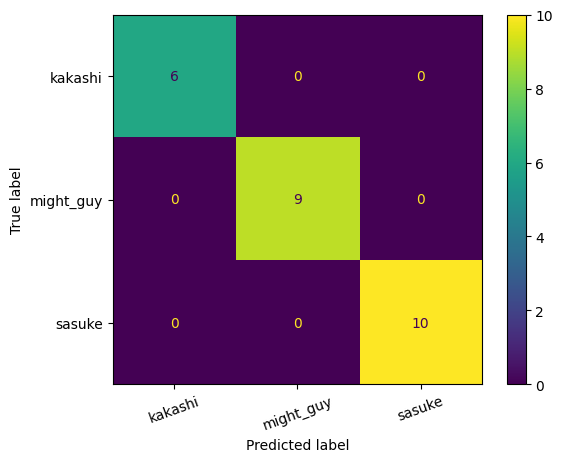

In [32]:
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224

TEST_DIR = Path("data/external_test")

test_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

test_ds = datasets.ImageFolder(TEST_DIR, transform=test_tfms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# ВАЖНО: классы в external_test должны совпадать по названиям папок
print("test classes:", test_ds.class_to_idx)

# загрузка лучшей модели
model = timm.create_model("convnext_tiny", pretrained=False, num_classes=len(test_ds.class_to_idx)).to(device)
model.load_state_dict(torch.load("best_convnext_tiny.pth", map_location=device, weights_only=True))
model.eval()

criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def eval_loader(model, loader):
    all_preds, all_true = [], []
    total_acc = 0
    n = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)
        all_preds.append(pred.cpu())
        all_true.append(y.cpu())
        total_acc += (pred == y).sum().item()
        n += y.size(0)
    all_preds = torch.cat(all_preds).numpy()
    all_true = torch.cat(all_true).numpy()
    return total_acc / n, all_preds, all_true

acc, y_pred, y_true = eval_loader(model, test_loader)
print("External test accuracy:", acc)

labels = list(test_ds.class_to_idx.keys())
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(values_format="d")
plt.xticks(rotation=20)
plt.title("")
plt.show()


# Testing on one photo (if nedeed)

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224

idx_to_class = {0:"kakashi", 1:"might_guy", 2:"sasuke"}

tfm = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

model = timm.create_model("convnext_tiny", pretrained=False, num_classes=3).to(device)
model.load_state_dict(torch.load("best_convnext_tiny.pth", map_location=device, weights_only=True))
model.eval()

img = Image.open("data/single_test.jpg").convert("RGB")
x = tfm(img).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(x)
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

pred_idx = probs.argmax()
print("Prediction:", idx_to_class[pred_idx])
print("Probabilities:", {idx_to_class[i]: float(probs[i]) for i in range(3)})


Prediction: kakashi
Probabilities: {'kakashi': 0.9972027540206909, 'might_guy': 8.000820525921881e-05, 'sasuke': 0.002717253053560853}
